In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('DMCHY.csv')
test = pd.read_csv('DMCHY.csv')

In [3]:
metric = 'Open' # What matric to model and predict
timestamp = 64 # Maximum number of timestamps to learn from
layers = 3 # Number of layers in LSTM
neurons = 264 # Number of neurons in each layer
epochs = 64 # Number of times the entire data needs to be looped upon
batch_size = 16 # Weights updated after n rows
validation_split = 0.1 # Percentage of data to validate the model when training
dropout = 0.2 # Regularisation parameter
optimizer = 'adam' 
loss = 'mean_squared_error'

In [4]:
loc = train.columns.get_loc(metric)
train_data = train.iloc[:,loc:loc + 1].values

In [5]:
sc = MinMaxScaler(feature_range = (0,1))

train_data = sc.fit_transform(train_data)

In [6]:
train_x = []
train_y = []
for i in range(0, len(train_data) - timestamp - 1):
    train_x.append(train_data[i : i + timestamp, 0])
    train_y.append(train_data[i + timestamp, 0])
train_x, train_y = np.array(train_x), np.array(train_y)

In [7]:
train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))

In [8]:
regressor = Sequential()
regressor.add(LSTM(neurons, return_sequences = True, input_shape = (train_x.shape[1],1)))
regressor.add(Dropout(dropout))

if layers > 2:
    for i in range(2,layers):
        regressor.add(LSTM(neurons, return_sequences = True))
        regressor.add(Dropout(dropout))

regressor.add(LSTM(neurons))
regressor.add(Dropout(dropout))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = optimizer,loss = loss)

In [9]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 264)           280896    
                                                                 
 dropout (Dropout)           (None, 64, 264)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64, 264)           558624    
                                                                 
 dropout_1 (Dropout)         (None, 64, 264)           0         
                                                                 
 lstm_2 (LSTM)               (None, 264)               558624    
                                                                 
 dropout_2 (Dropout)         (None, 264)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [10]:
regressor.fit(train_x,train_y,epochs = epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/64
25/25 [==============================] - 16s 384ms/step - loss: 0.0758 - val_loss: 4.7582e-04
Epoch 2/64
25/25 [==============================] - 8s 306ms/step - loss: 0.0080 - val_loss: 6.2075e-04
Epoch 3/64
25/25 [==============================] - 8s 328ms/step - loss: 0.0059 - val_loss: 6.7150e-06
Epoch 4/64
25/25 [==============================] - 9s 355ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 5/64
25/25 [==============================] - 9s 349ms/step - loss: 0.0058 - val_loss: 4.6485e-05
Epoch 6/64
25/25 [==============================] - 8s 329ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 7/64
25/25 [==============================] - 8s 311ms/step - loss: 0.0049 - val_loss: 9.8995e-06
Epoch 8/64
25/25 [==============================] - 8s 318ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 9/64
25/25 [==============================] - 8s 309ms/step - loss: 0.0059 - val_loss: 6.3472e-05
Epoch 10/64
25/25 [==============================] - 8s 316ms/step - loss: 

In [11]:
test_data = pd.concat((train[len(train) - timestamp:][metric], test[metric]), axis = 0)
test_data = test_data.values
test_data = test_data.reshape(-1,1)

In [12]:
test_data = sc.transform(test_data)

In [13]:
test_x = []
test_y = []
for i in range(0, len(test_data) - timestamp - 1):
    test_x.append(test_data[i : i + timestamp, 0])
    test_y.append(test_data[i + timestamp, 0])
test_x, test_y = np.array(test_x), np.array(test_y)

In [14]:
test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))

In [15]:
predicted_price = sc.inverse_transform(regressor.predict(test_x))
real_stock_price = test[metric]

16/16 [==============================] - 5s 216ms/step


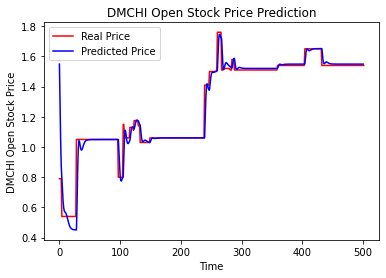

In [16]:
def plot_pred(metric, real_stock_price, predicted_price):
    plt.plot(real_stock_price,color = 'red', label = 'Real Price')
    plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
    plt.title('DMCHI ' +metric+ ' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('DMCHI ' +metric+ ' Stock Price')
    plt.legend()
    plt.show()

plot_pred(metric, real_stock_price, predicted_price)